In [1]:
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

**CNN Architecture:**

`Input Image → Conv Layers → Pooling → Conv Layers → Pooling → Fully Connected → Output`

**Computer Vision Dataset**

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 186kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.46MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 28.3MB/s]


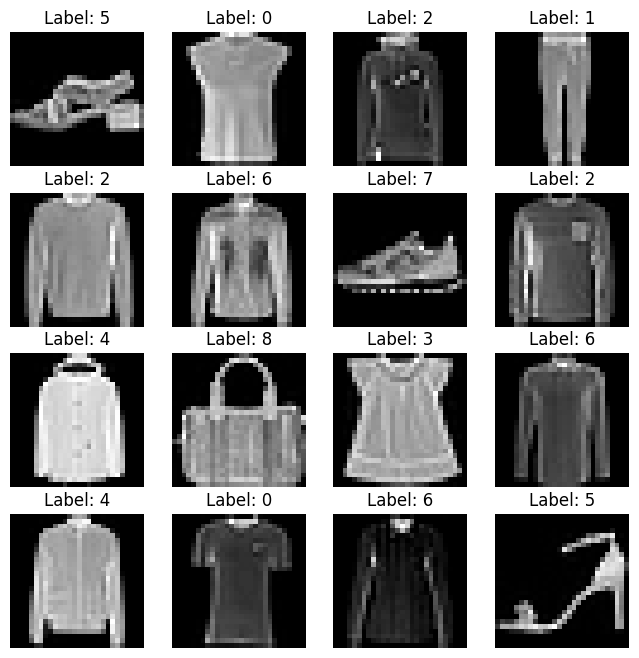

In [2]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),  # Convert PIL Image to tensor
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)


figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


**Mini-Batches and DataLoaders**

In [3]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Don't shuffle test data
    num_workers=0
)

for batch_X, batch_y in train_loader:
    print(f"Batch shape: {batch_X.shape}")  # [batch_size, channels, height, width]
    print(f"Labels shape: {batch_y.shape}")  # [batch_size]
    break

Batch shape: torch.Size([32, 1, 28, 28])
Labels shape: torch.Size([32])


**Training and Testing Loops**

In [12]:
def train(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        train_loss += loss

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc


In [5]:
def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == y).sum().item() / len(y_pred)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

**Creating a CNN**

In [6]:
class CNN(nn.Module):
    def __init__(self, input_shape, hidden_unit, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_unit * 7 * 7, output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


model = CNN(input_shape=1, hidden_unit=32, output_shape=10)

In [8]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 43,754
Trainable parameters: 43,754


In [9]:
print(model)

CNN(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=10, bias=True)
  )
)


**Run Training on GPU**

In [10]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [14]:
model = model.to(device)
NUM_EPOCHS = 20

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(model, train_loader, loss, optimizer, device)
    test_loss, test_acc = test_step(model, test_loader, loss, device)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


Epoch 5/20
Train Loss: 0.2193 | Train Acc: 0.92%
Test Loss: 0.2673 | Test Acc: 0.90%
Epoch 10/20
Train Loss: 0.1959 | Train Acc: 0.93%
Test Loss: 0.2563 | Test Acc: 0.91%
Epoch 15/20
Train Loss: 0.1770 | Train Acc: 0.94%
Test Loss: 0.2487 | Test Acc: 0.91%
Epoch 20/20
Train Loss: 0.1614 | Train Acc: 0.94%
Test Loss: 0.2429 | Test Acc: 0.92%


**Making Predictions on Random Samples**

In [15]:
def make_predictions(model, data, device):
    model.eval()
    image, label = data[torch.randint(0, len(data), size=(1,)).item()]

    with torch.no_grad():
        image = image.unsqueeze(dim=0).to(device)
        pred_logit = model(image)
        pred_prob = torch.softmax(pred_logit, dim=1)
        pred_label = torch.argmax(pred_prob, dim=1)

    return image, label, pred_label, pred_prob


image, true_label, pred_label, pred_prob = make_predictions(model, test_data, device)
print(f"True label: {true_label}")
print(f"Predicted label: {pred_label.item()}")
print(f"Prediction probability: {pred_prob.max().item():.2%}")


True label: 0
Predicted label: 0
Prediction probability: 99.96%


**nn.Conv2d and nn.MaxPool2d**

In [16]:
# Conv2d parameters
conv_layer = nn.Conv2d(
    in_channels=1,      # Input channels (grayscale=1, RGB=3)
    out_channels=10,    # Number of filters
    kernel_size=3,      # Filter size (3x3)
    stride=1,           # Step size
    padding=1           # Padding to maintain size
)

# MaxPool2d parameters
pool_layer = nn.MaxPool2d(
    kernel_size=2,      # Pooling window size
    stride=2            # Step size (usually same as kernel_size)
)


x = torch.randn(1, 1, 28, 28)  # [batch, channels, height, width]
print(f"Input shape: {x.shape}")

# After Conv2d
x = conv_layer(x)
print(f"After Conv2d: {x.shape}")  # [1, 10, 28, 28] (with padding=1)

# After MaxPool2d
x = pool_layer(x)
print(f"After MaxPool2d: {x.shape}")  # [1, 10, 14, 14]

Input shape: torch.Size([1, 1, 28, 28])
After Conv2d: torch.Size([1, 10, 28, 28])
After MaxPool2d: torch.Size([1, 10, 14, 14])
